In [13]:
import sys
print(sys.version)

import tensorflow as tf
print(tf.__version__)

import numpy as np
np.set_printoptions(threshold=np.inf)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:52:09) 
[Clang 14.0.6 ]
2.12.0


x.shape: (50000, 32, 32, 3) y.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3) y_test.shape: (10000, 1)
y[:5]: [[6]
 [9]
 [9]
 [4]
 [1]]


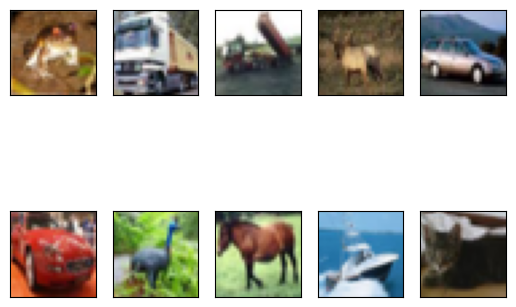

In [14]:
"""
1. 导入数据
获取系统自带的10分类图像数据，50k张用于训练，10k张用于测试。
"""
# 10分类卷积神经网络
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential,optimizers,layers,datasets
 
#（1）数据获取
(x,y), (x_test, y_test) = datasets.cifar10.load_data()
 
# 查看数据
print('x.shape:',x.shape,'y.shape:',y.shape)
print('x_test.shape:',x_test.shape,'y_test.shape:',y_test.shape)
print('y[:5]:',y[:5])
# x.shape: (50000, 32, 32, 3) y.shape: (50000, 1)
# x_test.shape: (10000, 32, 32, 3) y_test.shape: (10000, 1)
 
#（2）图像可视化
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x[i])
    plt.xticks([])
    plt.yticks([])
plt.show()

In [15]:
"""
2. 数据预处理
将图像的每个像素值从[0,255]映射到[-1,1]之间，由于目标值y的shape为[b,1]需要把shape为1的轴挤压掉tf.squeeze()，留下分类数值。
对所有的训练和测试数据集重新洗牌.shuffle()，但不打乱x和y之间的对应关系。每次迭代从数据集中取出128个样本，.batch(128)
"""
#（3）数据预处理
def processing(x,y):
    x = 2 * tf.cast(x, tf.float32) / 255.0 - 1  # [-1,1]
    y = tf.cast(y, tf.int32)
    return(x,y)
 
# 构造训练集数据集
y = tf.squeeze(y, axis=1)  # 挤压掉shape=1的轴
train_ds = tf.data.Dataset.from_tensor_slices((x,y))
train_ds = train_ds.map(processing).shuffle(10000).batch(128) # 打乱数据集，每次迭代取128个数据
 
# 构造测试集数据集，不需要onehot编码，需要和预测结果比较
y_test = tf.squeeze(y_test, axis=1) 
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
test_ds = test_ds.map(processing).shuffle(10000).batch(128) 
 
# 构造迭代器，查看划分是否正确
sample = next(iter(train_ds)) # 每次运行从数据集中取出一组xy
print('x_batch:', sample[0].shape, 'y_batch:', sample[1].shape)
# x_batch: (64, 128, 128, 3) y_batch:  (128,)

x_batch: (128, 32, 32, 3) y_batch: (128,)


2024-06-14 16:49:27.777985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype uint8 and shape [50000,32,32,3]
	 [[{{node Placeholder/_0}}]]
2024-06-14 16:49:27.778103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [50000]
	 [[{{node Placeholder/_1}}]]


In [16]:
"""
3. 构造网络
使用函数方法自定义网络各层，layers.BatchNormalization()为batchnorm层，在把输入送入至非线性函数之前，能有效的将数据控制在一定的范围内，
使网络更稳定，收敛更快。如果使用该层，训练集和测试集的使用的方法不同，训练时需要指定net(x, training=True)，BN层的参数在正反向传播过程中会被优化更新。
测试时指定net(x, training=False)。BN层的参数在正反向传播过程中不会被更新。
"""
#（4）网络构造
# 自定义网络层
def CNN(classes, input_shape):
    
    # 输入层
    inputs = tf.keras.Input(shape=input_shape)
    # 卷积层
    x = layers.Conv2D(32, kernel_size=(3,3), strides=1, kernel_regularizer=keras.regularizers.l2(0.001), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, kernel_size=(3,3), strides=1, padding='same')(x)
    # BN层
    x = layers.BatchNormalization()(x)
    # relu层
    x = layers.Activation('relu')(x)    
    # 池化层
    x = layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
    
    # unit2
    x = layers.Conv2D(64, kernel_size=(3,3), strides=1, kernel_regularizer=keras.regularizers.l2(0.001), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, kernel_size=(3,3), strides=1, padding='same')(x)
    # BN层
    x = layers.BatchNormalization()(x)
    # relu层
    x = layers.Activation('relu')(x)    
    # 池化层
    x = layers.MaxPool2D(pool_size=(2,2), strides=2, padding='same')(x)
  
    # Flatten层 连接卷积层和全连接层
    x = layers.Flatten()(x)
    
    # 全连接层
    x = layers.Dense(128, activation='relu')(x)
    
    # Dropout层
    x = layers.Dropout(0.2)(x)    
    
    # 全连接层
    x = layers.Dense(64, activation='relu')(x)
    
    # Dropout层
    x = layers.Dropout(0.2)(x)
    
    # logits层，不转为概率
    outputs = layers.Dense(classes)(x)
 
    # 构建网络
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    # 返回网络结构
    return model
 
# 传入函数所需参数
model = CNN(10, (32, 32, 3))  # 指定10个分类，输入的一张图片的shape为(32,32,3)
 
# 查看网络结构
model.summary()
 
# 指定优化器
optimizer = optimizers.legacy.Adam(learning_rate=0.0001,  beta_1=0.9, beta_2=0.99)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                       

In [18]:
"""
4. 网络训练
为了得到和model.fit()一样的效果，训练过程和测试过程都计算一下损失和准确率，并将每一次迭代的结果保存下来。指定model(x, trainin=True)更新BN层参数。
计算交叉熵损失时，categorical_crossentropy(y, logits, from_logits=True)，logits为每张图片属于各个分类的实数值，
指定from_logits=True，logits会自动经过softmax函数变成概率再和真实值y比较，提高了网络的稳定性。
"""
# 保存每次循环的损失和准确率
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
 
# 大循环
for epochs in range(10):  # 循环10次
    print('---------------')
    print('epochs:', epochs)
    
    #（5）网络训练
    total_sum = 0
    total_correct = 0
    total_loss = 0    
 
    for step, (x,y) in enumerate(train_ds):
        # 梯度跟踪
        with tf.GradientTape() as tape:
            # 前行传播，[b,32,32,3]=>[b,10]
            logits = model(x, training=True)  # 得到logits层输出后的10分类数值
            
            # 计算准确率
            # 将logits层输出结果转概率
            prob = tf.nn.softmax(logits, axis=1)
            # 找到概率最大值对应的索引
            predict = tf.argmax(prob, axis=1, output_type=tf.int32)
            # 预测值和真实值是否相同
            correct = tf.cast(tf.equal(predict, y), tf.int32)
            # 计算预测对了几个
            correct_sum = tf.reduce_sum(correct)
            # 计算总个数
            total_correct += correct_sum  # 总预测对了几个
            total_sum += x.shape[0]  # 总共有多少参与
            
 
            # 计算损失
            y = tf.one_hot(y, depth=10)  # 真实值y是onehot编码后的
            # 计算交叉熵损失
            CE = tf.losses.categorical_crossentropy(y, logits, from_logits=True)
            # 计算每个batch的平均损失
            loss = tf.reduce_mean(CE)
            
            # 记录batch总损失
            loss_sum = tf.reduce_sum(CE)
            total_loss += loss_sum
        
 
        # 梯度计算
        grads = tape.gradient(loss, model.trainable_variables)  # 对所有的权重和偏置计算梯度
        # 更新梯度
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # 每100个batch打印一次损失
        if step%100 == 0:
            print('step:', step, 'loss:', loss.numpy())
    
    
    # 保存训练的准确率和损失
    # 计算每次循环的准确率
    train_acc = total_correct/total_sum
    train_acc_list.append(train_acc)
    # 计算每次循环的损失
    train_loss = total_loss/total_sum
    train_loss_list.append(train_loss)
    
    # 每次循环后打印一次
    print('train_acc:', train_acc.numpy(), 'train_loss:', train_loss.numpy())
    """
    5. 网络测试
    用和训练过程相同的方法计算损失和准确率，但不需要更新梯度，将每一次迭代的结果保存下来。
    """
        #（6）网络测试
    total_sum = 0
    total_correct = 0
    total_loss = 0
    
    for (x,y) in test_ds:
        # 前向传播，得到输出层结果
        logits = model(x, training=False)  # 不更新BN层参数
        # 转换成每张图片属于每个分类的概率
        prob = tf.nn.softmax(logits, axis=1)
        # 概率最大的值的索引
        predict = tf.argmax(prob, axis=1, output_type=tf.int32)
        # 预测值和真实值比较，相同返回1
        correct = tf.cast(tf.equal(predict, y), dtype=tf.int32)
        # 计算相同的个数之和
        correct_sum = tf.reduce_sum(correct)
        
        # 计算准确率
        total_correct += int(correct_sum)  # 预测对了几个
        total_sum += x.shape[0]  # 一共有多少个参与预测
        
        # 计算测试集损失
        y = tf.one_hot(y, depth=10)  # 测试集的目标进行onehot编码后与预测得到的结果计算交叉熵损失
        loss = tf.reduce_sum(tf.losses.categorical_crossentropy(y, logits, from_logits=True)) # 每一个batch的总损失
        total_loss += loss   # 记录整个循环的损失和
        
        
    # 每个大循环计算一次损失及准确率
    test_loss = total_loss/total_sum 
    test_acc = total_correct/total_sum
    print('test_loss:', test_loss.numpy(),'test_acc:', test_acc)
    
    # 保存
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

---------------
epochs: 0
step: 0 loss: 2.8564076
step: 100 loss: 1.9831812
step: 200 loss: 1.8185592
step: 300 loss: 1.5789024
train_acc: 0.33764 train_loss: 1.823743


2024-06-14 16:53:05.399056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]
2024-06-14 16:53:05.399183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


test_loss: 2.3466403 test_acc: 0.2154
---------------
epochs: 1
step: 0 loss: 1.6119919
step: 100 loss: 1.6246437
step: 200 loss: 1.6435046
step: 300 loss: 1.477635
train_acc: 0.46668 train_loss: 1.4898908
test_loss: 1.2781255 test_acc: 0.5462
---------------
epochs: 2
step: 0 loss: 1.3850497
step: 100 loss: 1.5391464
step: 200 loss: 1.3928053
step: 300 loss: 1.3535254
train_acc: 0.5226 train_loss: 1.339806
test_loss: 1.1902184 test_acc: 0.5771
---------------
epochs: 3
step: 0 loss: 1.4121406
step: 100 loss: 1.1604844
step: 200 loss: 1.3401065
step: 300 loss: 1.2588285
train_acc: 0.56886 train_loss: 1.2247648
test_loss: 1.1280034 test_acc: 0.6035
---------------
epochs: 4
step: 0 loss: 1.042034
step: 100 loss: 1.1284759
step: 200 loss: 1.0717709
step: 300 loss: 1.2257636
train_acc: 0.60056 train_loss: 1.1325576
test_loss: 1.0321203 test_acc: 0.6376
---------------
epochs: 5
step: 0 loss: 0.9193766
step: 100 loss: 1.2053971
step: 200 loss: 1.0013914
step: 300 loss: 1.001982
train_acc: 

Text(0.5, 1.0, 'Loss')

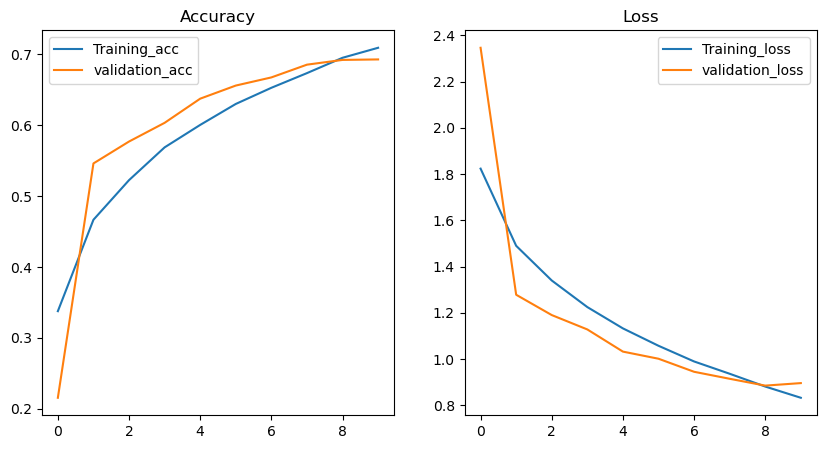

In [19]:
"""
7. 模型评估
绘制训练集和验证集的准确率和损失的对比曲线，来对网络优个直观的感受。可见前10次迭代收敛平缓，效果较好，随着迭代次数的增加可能会出现过拟合现象。
"""
epochs_range = range(len(train_loss_list))  # 横坐标，网络循环了几次
 
# 准确率曲线
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, train_acc_list, label='Training_acc')
plt.plot(epochs_range, test_acc_list, label='validation_acc')
plt.legend()
plt.title('Accuracy')
# 损失曲线
plt.subplot(1,2,2)
plt.plot(epochs_range, train_loss_list, label='Training_loss')
plt.plot(epochs_range, test_loss_list, label='validation_loss')
plt.legend()
plt.title('Loss')